# "Airbnb Recommends" Revenue Optimization Experiment

Arlyss Gease Data-201 Capstone 1

## Introduction

This document outlines an experiment aimed to increase Airbnb company revenues by nudging guests towards underutilized high-revenue potential listings using an "Airbnb Recommends" icon to attract guests to those listings. 

This document includes:

   - Details on the hypothesis and experimental design
   - An evaluation plan for the experiment
   - Preliminary analysis of a proposed test market: San Francisco 

## Hypothesis Formation

### Hypothesis to Test 
Our most basic hypothesis is that Airbnb can improve revenues by nudging users away from overutilized low-price properties towards underutilized moderate-to-high priced properties. More specifically, we propose to test the following hypothesis:

<b>Hypothesis:</b> Airbnb can increase revenue by deploying an "Airbnb Recommends" icon for display on underutilized high satisfaction moderate-to-high priced listings. 

We propose to test this experiment by deploying the "Airbnb Recommends" label in one major US market: San Francisco. We have conducted a preliminary analysis of the market based on data scraped from the Airbnb website. As historic bookings data is not available, we use reviews as a proxy for stays.

### Supporting Analysis
Given that Airbnb company revenue is proportionate to listing revenue, and listing revenue is driven by price and quantity of stays, directing stays towards higher-priced properties will, other things equal, increase revenue.

As can be seen in <b>Figure 1</b>, low-priced listings generate an outsized number of monthly reviews.

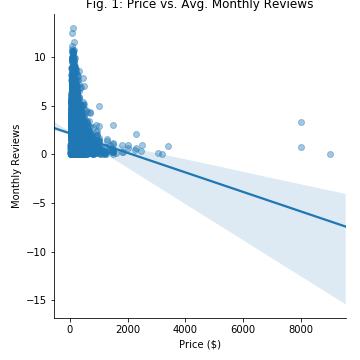

In [187]:
Image('fig_1.png', width=400, height=400)

![title](img/fig_1.png)

Excluding price outliers shows a heavy concentration of reviews in listings with a daily price of less than $200 over the past 12 months (<b>Figure 2</b>).

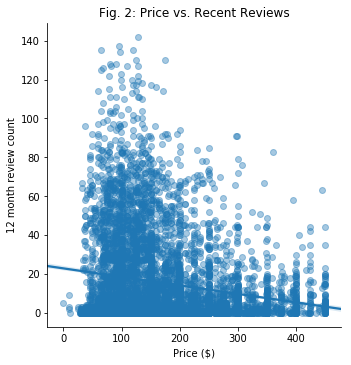

To verify that this skew is not just due to more avilailability in lower-priced listings, we use the ratio of ((reviews from the last 12 months) / (availability in the next 12 months)) as a proxy for utilization (considering only properties with estimated utilization between 0 and 1). <b>Figure 3</b> shows lower utilization of higher-priced properties.

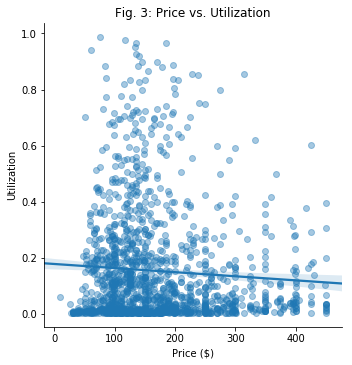

Note that while this chart supports of hypothesis, only 28% of properties had real utilization values from 0 to 1. In the experiment, we recommend actual using actual 12-month utilization in place of this proxy.

## Experiment Proposal

We focus our proposed experiment on this population.

<b>Qualified Population:</b> A listing qualifies for the test if it meets the following three criteria.

- Daily price of at least $200
- Satisfaction above 90%
- Estimated utilization below 50%

Of all listings, 34% of listings have a price greater than or equal to $200, 83% of listings have satisfaction above 90%, and, of listings with utilization estimates from 0 to 1, 93% have utilization of <50%. Of all listings, 9% (645) meet all three criteria. We are confident that the population could be significantly expanded if actual utilization were used in place of estimated utilization.

Given a small trial on a population of only 645 listings, we would recommend that half of listings receive an "Airbnb Recommends" icon in search results after initial testing of the icon and its visibility on test accounts. If a change in the measure of estimated utilization results in the option to significantly expand the experiment, we would recommend doing so in batches to avoid deleterious market effects.

<b>Experimental Group:</b> Random selection of 322 qualified listings to receive an "Airbnb Recommends" icon.

<b>Control Group:</b> Remaining 323 qualified listings with no "Airbnb Recommends" icon.

We recommend tracking these groups along the following dimensions:

- <b>(primary outcome)</b> number of reviews received
- listing price
- utilizaiton of availability

Each week after the initiation of the experiment, the experimental and control groups should be compared on these dimensions

- change in number of reviews in the X weeks since the experiment began and the X weeks <i>prior</i>
- <i>percentage</i> change in reviews in the X weeks since the experiment began and the X weeks prior
- change in listing price in the X weeks since the experiment began and the X weeks prior
- percentage change in listing price in the X weeks since the experiment began and the X weeks prior
- utilizaiton of availability in the X weeks since the experiment began and the X weeks prior

We recommend testing the significance (p-values) of changes on each of these dimensions.

In [188]:
#exmaple math

## Appendix: Supporting Analyses

In [3]:
%matplotlib inline
import pandas as pd
import math
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from datetime import date

In [4]:
calendar = pd.read_csv('calendar (sf).csv')
listings = pd.read_csv('listings (sf).csv')
reviews  = pd.read_csv('reviews (sf).csv')

Our goal is to optimize revenue, which is driven by listing price and the number of reviews over time. First, we create a data frame to review the price and monthly reviews data from the listings table.

In [5]:
df = pd.DataFrame()
df['listing_id'] = listings['id']
df['reviews_monthly'] = listings['reviews_per_month']
df['price ($)'] = listings['price'].apply(lambda x: float(''.join(list(filter(str.isdigit, str(x))))))/100

As expected, price and monthly reviews are inversely correlated, as shown here:

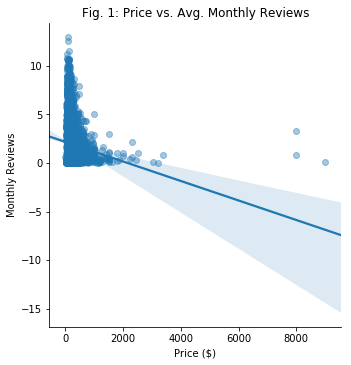

In [177]:
#Fig 1
scatter = sns.lmplot(y='reviews_monthly', x='price ($)', data=df, 
               fit_reg=True, scatter_kws={'alpha':0.4})
scatter.set_ylabels("Monthly Reviews")
scatter.set_xlabels("Price ($)")
plt.title('Fig. 1: Price vs. Avg. Monthly Reviews')
plt.savefig('fig_1.png')
plt.show()

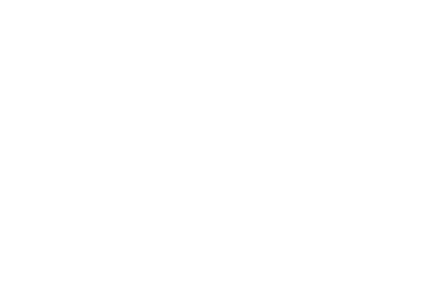

In [158]:
from IPython.display import Image
Image(filename = "fig_1.png", width=100, height=100)


To improve our analysis, we throw out high-price outliers, and count the number of reviews received in the last 12 months to ensure review volumes are up to date.

In [8]:
#add a columns to the review table to indicate year, month, and whether the review is our 12 month range
reviews['review_year'] = 0
for i in reviews.index:
    reviews.at[i,'review_year'] = int(reviews.at[i,'review_date'][-2:])
reviews['review_month'] = 0
for i in reviews.index:
    reviews.at[i,'review_month'] = int(reviews.at[i,'review_date'][:2].replace('/', ''))
reviews['12_mo_range'] = False
for i in reviews.index:
    if reviews.at[i,'review_year'] == 18 and reviews.at[i,'review_month']<10:
        reviews.at[i,'12_mo_range'] = True
    elif reviews.at[i,'review_year'] == 17 and reviews.at[i,'review_month']>9:
        reviews.at[i,'12_mo_range'] = True  

In [9]:
#add the count of reviews in the last 12 months to df
reviews_oct17_sept18 = reviews[reviews['12_mo_range']][['listing_id','id']].groupby('listing_id').aggregate('count')['id']
reviews_oct17_sept18
df['reviews_12_mo'] = 0
for i in reviews_oct17_sept18.index:
    df.at[df[df['listing_id']==i].index.tolist()[0],'reviews_12_mo'] = reviews_oct17_sept18[i]
        
#for i in df.index:
#    df.at[i,'reviews_12_mo'] = reviews_oct17_sept18[df.at[i,'listing_id']] if df.at[i,'listing_id'] in reviews_oct17_sept18.index else 0
    

In [10]:
#add a column to df indicating whether price is an outlier
q1 = df['price ($)'].quantile([.25]).tolist()[0]
q3 = df['price ($)'].quantile([.75]).tolist()[0]
price_outlier = q3 + (q3 - q1)*1.5
price_outlier
df['price_outlier'] = False
for i in df.index:
    if df.at[i,'price ($)'] > price_outlier:
        df.at[i,'price_outlier'] = True

Now we can recreate the Price x Reviews plot using excluding price outliers and using our count of reviews in the last year

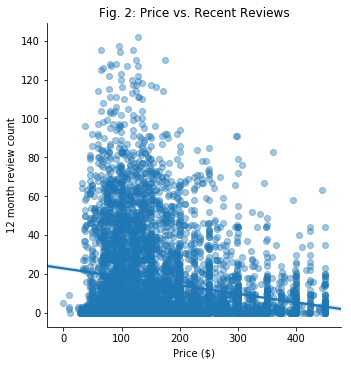

In [11]:
#Fig 2
scatter = sns.lmplot(y='reviews_12_mo', x='price ($)', data=df.where(df['price_outlier'] == False), 
               fit_reg=True, scatter_kws={'alpha':0.4})
scatter.set_ylabels("12 month review count")
scatter.set_xlabels("Price ($)")
plt.title('Fig. 2: Price vs. Recent Reviews')
plt.show()

Next we calculate the number of days each listing has available in 2019 according to the Calendar table.

In [12]:
calendar['year'] = 0
#maybe use -1 instead of 0
for i in calendar.index:
    calendar.at[i,'year'] = int(calendar.at[i,'calendar_date'][-2:])
    
calendar_2019 = calendar[calendar['year']==19].copy()

In [13]:
calendar_2019['availa_bool'] = False
for i in calendar_2019.index:
    calendar_2019.at[i,'availa_bool'] = (calendar_2019.at[i,'available'] == 't')

In [14]:
available_2019 = calendar_2019[calendar_2019['availa_bool']][['listing_id','availa_bool']].groupby('listing_id').aggregate('count')['availa_bool']

And add estimated utilization to the analysis table

In [75]:
df['availability'] = 0
for i in available_2019.index:
        df.at[df[df['listing_id']==i].index.tolist()[0],'availability'] = available_2019[i]
df['utilization'] = df['reviews_12_mo'] / df['availability']
df['0to1'] = False
for i in df.index:
    df.at[i,'0to1'] = not( math.isnan(df.at[i,'utilization']) or math.isinf(df.at[i,'utilization']) or (df.at[i,'utilization']>1))

In [63]:
df.head()

,listing_id,reviews_monthly,price ($),reviews_12_mo,price_outlier,availability,utilization,0to1,score
0,958,1.43,170.0,49,False,123,0.398374,True,97.0
1,5858,0.98,235.0,0,False,275,0.000000,True,98.0
2,7918,0.15,65.0,0,False,275,0.000000,True,85.0
3,8142,0.16,65.0,1,False,275,0.003636,True,93.0
4,8339,0.25,785.0,2,True,0,inf,False,97.0


In [79]:
# percentage of listings with valid utilizaiton 
df[df['0to1']].shape[0] / df.shape[0]

0.28397238137211694

In [91]:
# percentage of listings with price >= $200
df[df['price ($)'] >= 200].shape[0] / df.shape[0]

0.33876891435287204

In [65]:
df['score'] = listings['review_scores_rating']

In [89]:
# percentage of listings with review score greater than 90%
df[df['score'] >= .9].shape[0] / df['score'].shape[0]

0.8313500807991773

In [93]:
# percentage of listings with valid utilization with utilization < 50%
df[df['0to1']]['utilization'][df[df['0to1']]['utilization'] <.5].shape[0] / df[df['0to1']].shape[0]

0.9322296947749612

In [128]:
# listings meetig 
population = df[(df['price ($)'] >= 200) & df['0to1'] & (df['score'] >= .9)].shape[0]
percentage = df[(df['price ($)'] >= 200) & df['0to1'] & (df['score'] >= .9)].shape[0]*100 / df.shape[0]

print("Population is {} or {}% of all listings".format(population, percentage))

Population is 645 or 9.475539885412076% of all listings


In [88]:
# percentage of listings with 

0.5123305932015108

In [129]:
df[df['price ($)'] >= 200].shape[0] / df[df['price ($)'] < 200].shape[0]

0.5123305932015108

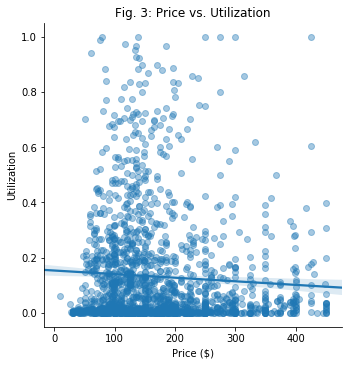

In [131]:
#Fig 3
scatter = sns.lmplot(y='utilization', x='price ($)', data=df.where(df['price_outlier'] == False).where(df['0to1'] == True), 
               fit_reg=True, scatter_kws={'alpha':0.4})
scatter.set_ylabels("Utilization")
scatter.set_xlabels("Price ($)")
plt.title('Fig. 3: Price vs. Utilization')
plt.show()